*Objetivo:* encontar o melhor modelo para a regressão da severidade de três defeitos:
* Desbalanceamento
* Desalinhamento vertical
* Desalinhamento horizontal


## Sumário
0. [Considerações](#consideracoes)
1. [Desbalanceamento](#desbalanceamento)
    * [Regressores simples](#modelos)
    * [TPOT](#TPOT)

In [1]:
import pandas as pd

#biliotecas para extração e visualização do FFT ou Periodogram (PSD) 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import aux_functions as aux

sns.set_theme()

In [2]:
df = pd.read_csv('../data.csv')

# adiciona a feature 1/fundamental
fundamental_inverse = df['fundamental'].apply(lambda x: 1/x)
df.insert(4, 'fund_inverse', fundamental_inverse)

# exibe fragmento dos dados
df.iloc[:,:6].head()

,defeito,severidade,rotacao,fundamental,fund_inverse,ac1ax_1h
0,desalinhamento_horizontal,0.5,12.2880,12.0240,0.083167,0.723810
1,desalinhamento_horizontal,0.5,13.5168,13.2264,0.075606,0.670464
2,desalinhamento_horizontal,0.5,14.5408,14.2284,0.070282,0.739682
3,desalinhamento_horizontal,0.5,15.3600,15.0300,0.066534,0.678096
4,desalinhamento_horizontal,0.5,16.3840,16.0320,0.062375,0.620058


## Considerações <a class="anchor" id="consideracoes"></a>
1. O valor 'fundamental' extraído do tacômetro representa melhor a velocidade do rotor do que o valor fornecido pela base. Por isso, dispensamos o último com `df.pop('rotacao')`

2. Cada ensaio (cada linha) apresenta apenas um tipo defeito dentre os três analisados. Como há três tipos distintos de defeito, cada um deve ser analisado separadamente.


In [3]:
df.pop('rotacao');

In [4]:
# separa cada tipo de defeito em um dataframe específico
df_desbal      =      df.query("defeito == 'desbalanceamento' or defeito == 'normal'")
df_des_ve      =      df.query("defeito == 'desalinhamento_vertical' or defeito == 'normal'")
df_des_ho      =      df.query("defeito == 'desalinhamento_horizontal' or defeito == 'normal'")

# cria dicionário que aponta o nome do defeito para o seu DataFrame
fault_to_df = {
    'desbalanceamento'         :   df_desbal,
    'desalinhamento_vertical'  :   df_des_ve,
    'desalinhamento_horizontal':   df_des_ho,
}

fault_list = ['desbalanceamento', 'desalinhamento_vertical', 'desalinhamento_horizontal']

In [5]:
# descarta a coluna 'defeito' de cada df, pois é informação redundante
for _, dfram in fault_to_df.items():
    dfram.pop('defeito')
    
fault_to_df['desalinhamento_vertical'].head()

,severidade,fundamental,fund_inverse,ac1ax_1h,ac1ax_2h,ac1ax_3h,ac1ax_entr,ac1ax_kurt,ac1ax_mean,ac1ax_rms,...,ac2tg_kurt,ac2tg_mean,ac2tg_rms,microfone_1h,microfone_2h,microfone_3h,microfone_entr,microfone_kurt,microfone_mean,microfone_rms
197,0.51,12.2244,0.081804,1.314350,0.685271,6.799286,1.926756,0.012352,-0.001213,25.692180,...,-0.431925,-0.020623,62.391259,0.972488,0.390341,1.943040,1.006946,1.228098,0.020396,9.516448
198,0.51,12.8256,0.077969,0.582629,1.103922,14.542427,1.896688,-0.452327,-0.000583,24.218310,...,0.093143,0.324467,66.245670,0.625937,0.506767,4.441556,0.888412,0.721683,0.011807,7.946951
199,0.51,14.6292,0.068356,0.563533,3.935806,0.842566,1.896409,-0.564041,-0.000793,24.217983,...,-0.118386,-0.033993,88.370957,0.646703,1.384931,0.665266,0.953006,0.132800,0.018378,8.867801
200,0.51,15.8316,0.063165,0.527811,14.141063,0.664993,1.908416,-0.470012,-0.002158,24.361031,...,-0.441469,-0.067903,62.329029,0.709394,4.423690,0.655683,0.889416,0.377087,0.012051,8.005840
201,0.51,16.6332,0.060121,0.680303,10.055396,0.603452,1.899257,-0.297248,-0.001335,24.184495,...,-0.933410,0.165706,125.096834,0.821151,3.222073,0.543422,0.889839,0.281509,0.010640,8.054550


# Desbalanceamento <a class="anchor" id="desbalanceamento"></a>

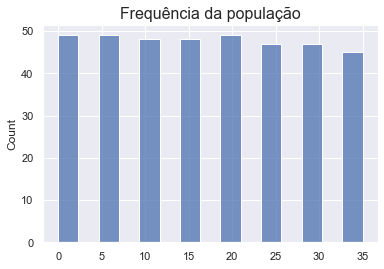

In [6]:
# armazena output em um array
output = np.array(df_desbal['severidade'])

# plota distribuição da população
sns.histplot(output, bins=15)
plt.title('Frequência da população', fontsize=16)
plt.show()

Dada a consideração 1, os dados de treino e teste possuem sempre muitos dados com 'defeito' = 0

In [7]:
# remove a coluna de outputs do df original
df_desbal.pop('severidade')

# salva a ordem das features
feature_list = list(df_desbal)

# converte df para array
data = np.array(df_desbal)

In [8]:
df_desbal.head()

,fundamental,fund_inverse,ac1ax_1h,ac1ax_2h,ac1ax_3h,ac1ax_entr,ac1ax_kurt,ac1ax_mean,ac1ax_rms,ac1rad_1h,...,ac2tg_kurt,ac2tg_mean,ac2tg_rms,microfone_1h,microfone_2h,microfone_3h,microfone_entr,microfone_kurt,microfone_mean,microfone_rms
498,13.6272,0.073383,0.614861,1.106082,0.418113,1.875901,-0.792840,0.000727,23.781015,6.966357,...,-0.142961,0.039913,48.052180,0.799733,0.122876,0.545375,0.931364,-0.017502,0.014242,8.726840
499,14.2284,0.070282,0.576935,1.100560,0.384907,1.864294,-0.869464,-0.000384,23.551378,5.608414,...,-0.293248,-0.019935,51.543861,0.701435,0.090301,0.716588,0.975597,-0.052881,0.017785,9.126381
500,15.4308,0.064805,0.626585,1.283208,10.063108,1.875905,-0.614587,0.000001,23.925685,4.343829,...,-0.265470,0.116550,50.609899,0.623781,0.770836,3.682855,1.005433,0.144308,0.018686,9.562646
501,16.2324,0.061605,0.447165,0.660919,14.666422,1.858617,-0.852201,0.002793,23.368037,5.357364,...,-0.364828,0.081646,45.340454,0.890845,0.781065,5.306885,0.936459,-0.345275,0.007922,8.856612
502,16.8336,0.059405,0.699053,0.719289,8.075579,1.877898,-0.551936,0.000520,23.894386,4.905962,...,-0.724785,-0.061868,127.442876,0.685346,0.571099,2.912441,0.960440,0.118109,0.012908,9.110052


### Avaliando modelos com K-Fold Crossvalidation

In [9]:
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, GroupKFold, StratifiedKFold

# kfold =           KFold(n_splits=8, shuffle=True, random_state=42)
kfold = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)

In [10]:
# encontra o melhor alpha para a regressão Ridge
from sklearn.linear_model import LassoLarsCV
reg = LassoLarsCV(cv=5).fit(data, output)
reg.alpha_

0.0056695116947966095

In [11]:
# encontra o melhor alpha para a regressão Lasso

In [12]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

import sklearn.metrics as metrics

modelos = [
    LinearRegression(),
    # Ridge(alpha=0.1),
    # Lasso(alpha=0.00567),
    # Pipeline([('poly', PolynomialFeatures(degree=2, interaction_only=True)),
    #           ('linear lasso', Lasso(alpha=0.00567))         ]),
    make_pipeline(StandardScaler(), 
                  SVR() ),
    KNeighborsRegressor(n_neighbors=3),
    DecisionTreeRegressor(),
    RandomForestRegressor(n_estimators= 10, random_state=42),
]

id_modelos = [
    'Regressão linear',
    # 'Regressão Ridge',
    # 'Lasso',
    # 'Linear Lasso Polinomial',
    'SVR',
    'KNN Regressor',
    'Árvore de decisão regressora',
    'Floresta aleatória regressora',
]

In [13]:
# usando cross-validation
resultados=[]
for modelo in modelos:
    result = cross_val_score(modelo, data, output, cv=kfold, scoring='neg_mean_absolute_error', n_jobs=-1)
    resultados.append(result)

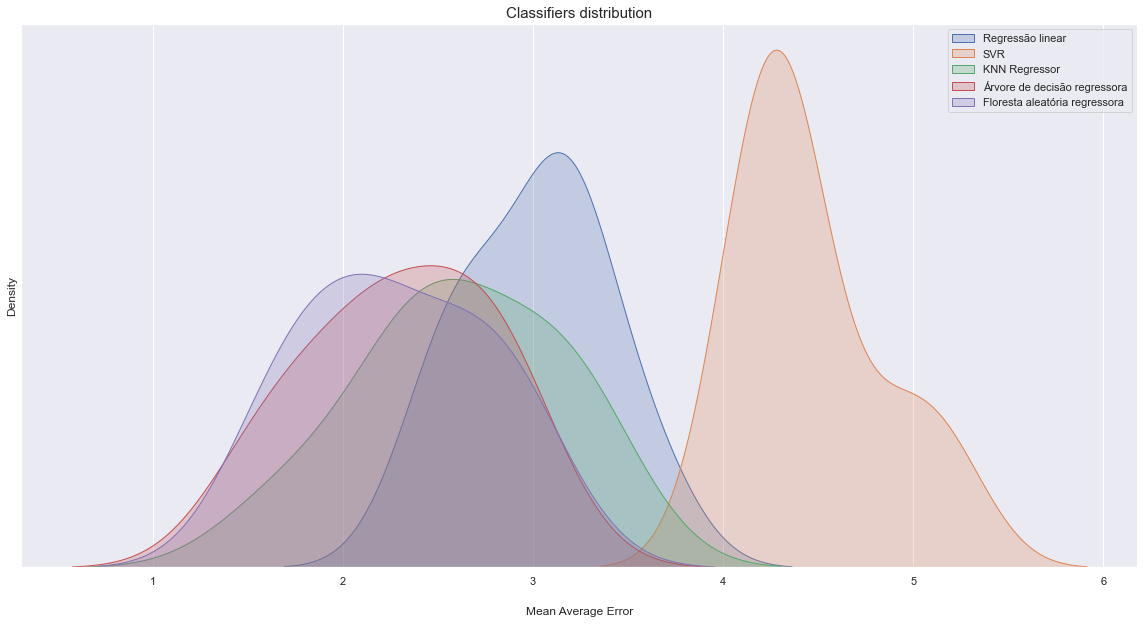

In [14]:
plt.figure(figsize=(20, 10))
for i, modelo in enumerate(id_modelos):
    sns.distplot(-resultados[i], hist=False, kde_kws={"shade": True})

plt.title("Classifiers distribution", fontsize=15)
plt.legend(id_modelos)
plt.xlabel("Mean Average Error", labelpad=20)
plt.yticks([])

plt.show()

### Visualizando modelos com Train-Test Split

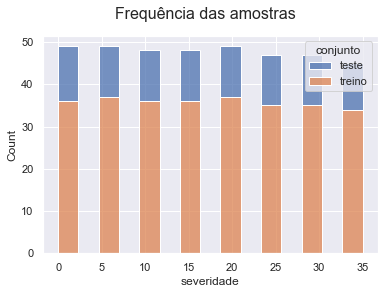

In [15]:
from sklearn.model_selection import train_test_split

# separa os conjuntos de treino e teste com amostragem estratificada,
# logo, mantendo a proporção para cada tipo de defeito
X_train, X_test, y_train, y_test = train_test_split(data, output, test_size = 0.25, stratify=output, random_state=42) 

output_amostrado = pd.DataFrame( {'severidade': np.concatenate((y_test, y_train)),
                                  'fundamental': np.concatenate((X_test[:,0], X_train[:,0])),
                                  'conjunto': ['teste']*len(y_test) + ['treino']*len(y_train)} )

sns.histplot(output_amostrado, x='severidade', stat="count", multiple="stack", hue='conjunto', bins=15)
plt.suptitle('Frequência das amostras', fontsize=16);

# sns.jointplot(data=output_amostrado, x='severidade', y='fundamental', hue='conjunto',
#                 kind='hist', bins=30, marginal_ticks=True, marginal_kws=dict(bins=15, fill=False, multiple="stack"));

In [16]:
resultados = [None]*len(id_modelos)
metricas = pd.DataFrame()

for i, item in enumerate(id_modelos):
    # treina os modelos com dados de treino
    modelos[i].fit(X_train, y_train)

    # prevê com o modelo a partir do conjunto de teste
    y_predicted = modelos[i].predict(X_test)

    # salva DataFrame com resultados
    resultados[i] = aux.gera_df_resultados(X_test, feature_list, y_predicted, y_test)

    # salva métricas com o desempenho do modelo
    metricas = pd.concat([ metricas, aux.gera_df_metricas(y_predicted, y_test, item) ], ignore_index=True)

metricas

,modelo,R2,MSE,RMSE,MAE
0,Regressão linear,0.882549,15.056363,3.880253,2.987603
1,SVR,0.691955,39.489131,6.284038,4.619292
2,KNN Regressor,0.792864,26.553241,5.152984,2.687500
3,Árvore de decisão regressora,0.884126,14.854167,3.854110,1.750000
4,Floresta aleatória regressora,0.868863,16.810729,4.100089,2.213542


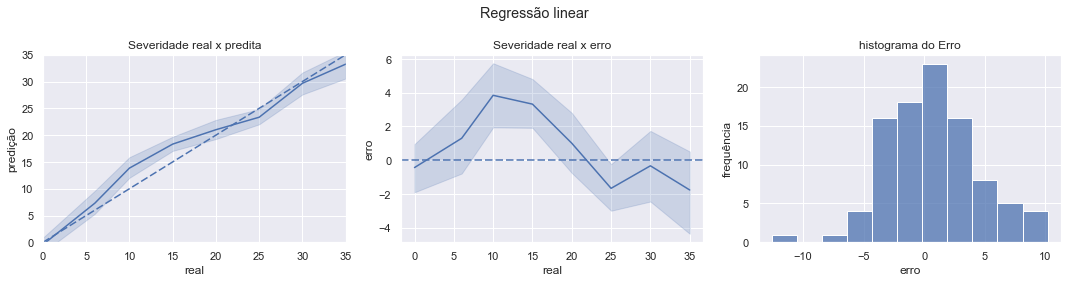

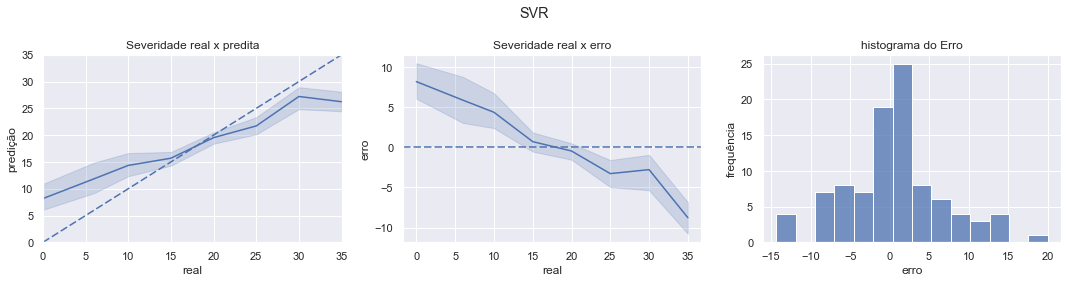

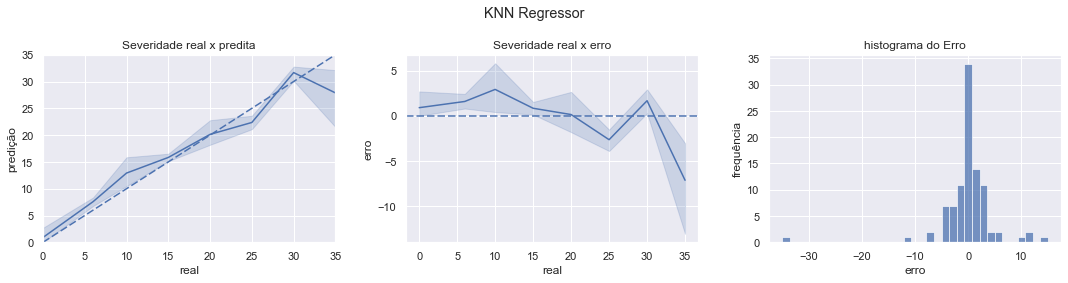

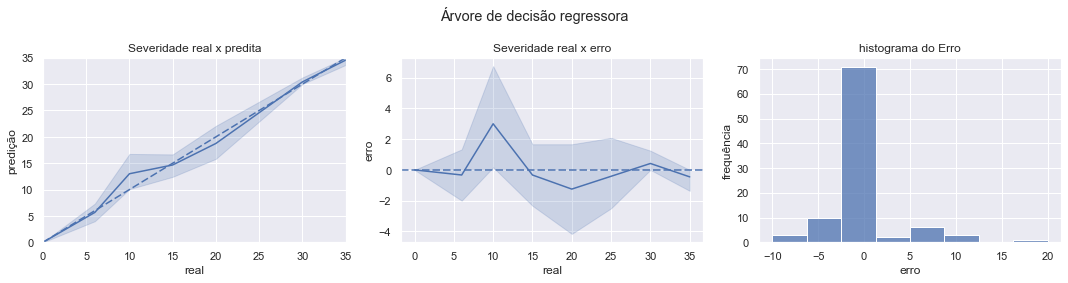

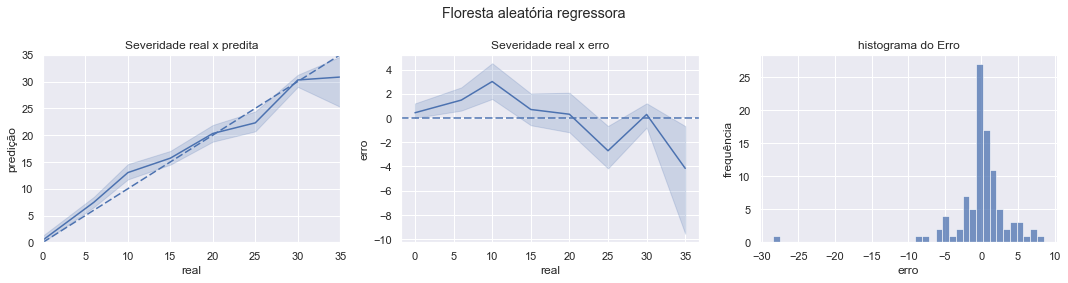

In [17]:
for i, item in enumerate(id_modelos):
    aux.plota_resultados(resultados[i], item, 'desbalanceamento')

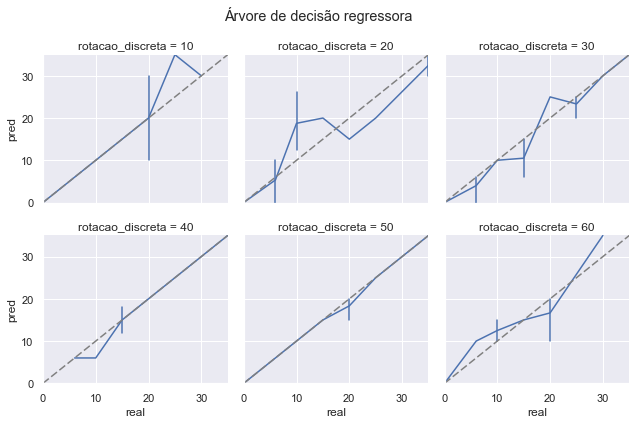

In [18]:
aux.plota_resultados_segregados(resultados[3], id_modelos[3], 'desbalanceamento')

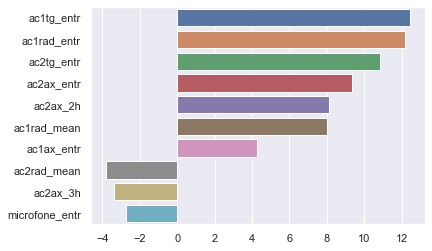

In [22]:
linear_regression = Ridge(alpha=0.1).fit(X_train, y_train)
coeficientes = pd.Series(linear_regression.coef_, index=feature_list)
coeficientes = coeficientes[coeficientes.abs().sort_values(ascending=False)[:10].index]
g = sns.barplot(y=coeficientes.index, x=coeficientes, orient='h')
# g.set_xticklabels(g.get_xticklabels(), rotation=90);

### Conclusão
?

# TPOT <a class="anchor" id="TPOT"></a>
TPOT é um algoritmo Auto_ML, que gera o modelo otimizado após testes exaustivos.

In [16]:
# a reexecução do TPOT pode levar horas, dias..

# from tpot import TPOTRegressor
# pipeline_optimizer_hor_mis = TPOTRegressor()
# pipeline_optimizer_hor_mis.fit(train_data, train_labels[:,0])

In [17]:
#  print(pipeline_optimizer_hor_mis.score(test_data, test_labels[:,0]))
#  pipeline_optimizer_hor_mis.export('tpot_pipeline_hor_mis.py')

### Modelo gerado pelo TPOT (após 1 dia de busca)

In [18]:
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import PolynomialFeatures
from tpot.builtins import StackingEstimator

# Average CV score on the training set was: -0.009330433709391846
exported_pipeline = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False, interaction_only=False),
    StackingEstimator(estimator=AdaBoostRegressor(learning_rate=1.0, loss="exponential", n_estimators=100)),
    RandomForestRegressor(bootstrap=False, max_features=0.4, min_samples_leaf=4, min_samples_split=16, n_estimators=100)
)


exported_pipeline.fit(X_train, y_train)
y_predicted = exported_pipeline.predict(X_test)


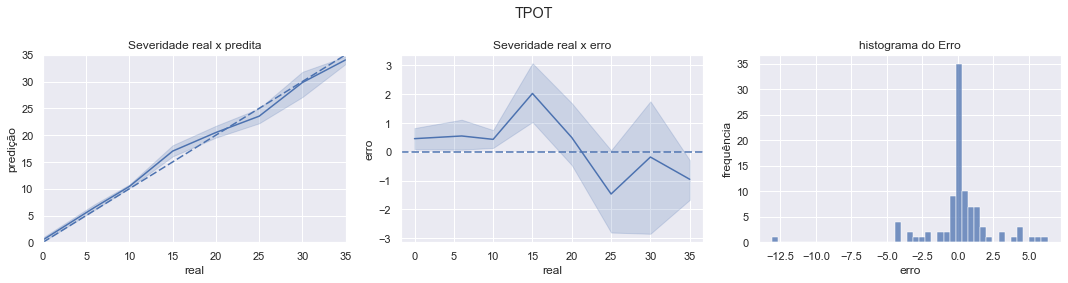

In [21]:
resultados_TPOT = aux.gera_df_resultados(X_test, feature_list, y_predicted, y_test)

aux.plota_resultados(resultados_TPOT, 'TPOT','desbalanceamento')

In [23]:
metricas = pd.concat([ metricas, aux.gera_df_metricas(y_predicted, y_test, 'TPOT') ], ignore_index=True)
metricas.head()

,modelo,R2,MSE,RMSE,MAE
0,Regressão linear,0.873926,15.774883,3.971761,2.987731
1,Regressão Ridge,0.866889,16.655371,4.081099,3.024982
2,SVR,0.387231,76.672092,8.756260,7.194447
3,Floresta aleatória regressora,0.921902,9.771979,3.126017,2.261458
4,TPOT,0.956442,5.450206,2.334568,1.304162


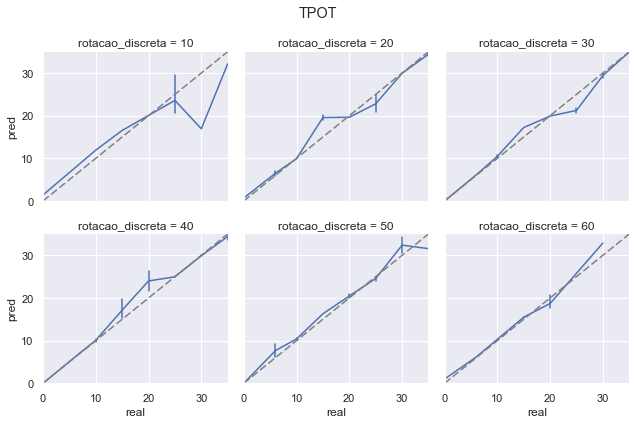

In [25]:
aux.plota_resultados_segregados(resultados_TPOT, 'TPOT', 'desbalanceamento')